# EJERCICIOS SPARK, Ejercicio 6 - Julia Hernández Elena

In [1]:
import os
import pandas as pd

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window


In [2]:
conf = (

    SparkConf()
    .setAppName(u"[ICAI] Ejercicios Spark")
    .set("spark.executor.memory", "7g")
    .set("spark.executor.cores", "5")
    .set("spark.default.parallelism", 600)
    .set("spark.sql.shuffle.partitions", 600) 
    .set("spark.dynamicAllocation.maxExecutors", 2) 
)

In [3]:
spark = (

    SparkSession.builder
    .config(conf=conf)
    .enableHiveSupport()
    .getOrCreate()

)

# EJERCICIO 6

In [4]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

### 1. Leer el csv situando en /datos/hour.csv del hdfs.

In [5]:
hour = (

    spark.read
    .options(header=True, inferSchema=True)
    .csv('/datos/hour.csv')
    
).cache() #lo dejamos en cache para trabajar mas rapido

In [64]:
hour.count()

17379

In [91]:
hour.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



### 2. Queremos hacer un modelo de ML para predecir la variable cnt, para ello haremos el primer preproceso:
- #### Eliminar del dataset las variables casual y registerd ya que ambas forman cnt.
- #### Eliminar también las variables instant y dteday ya que no se quieren usar en el modelo.

In [92]:
hour = hour.drop('casual', 'registered', 'instant', 'dteday')

In [93]:
hour.limit(5).toPandas()

season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0       1   0     1   0        0        6           0           1  0.24   
1       1   0     1   1        0        6           0           1  0.22   
2       1   0     1   2        0        6           0           1  0.22   
3       1   0     1   3        0        6           0           1  0.24   
4       1   0     1   4        0        6           0           1  0.24   

    atemp   hum  windspeed  registered  cnt  
0  0.2879  0.81        0.0          13   16  
1  0.2727  0.80        0.0          32   40  
2  0.2727  0.80        0.0          27   32  
3  0.2879  0.75        0.0          10   13  
4  0.2879  0.75        0.0           1    1

### 3. Dibujar en un gráfico la variable hr (hora del día) frente a la variable cnt ¿Qué se observa?

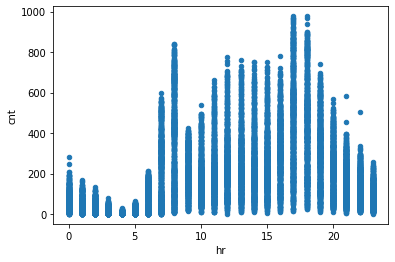

In [94]:
%matplotlib inline
hour.select("hr", "cnt").toPandas().plot.scatter(x="hr", y="cnt")

### 4. Dividir el dataset en muestra de entrenamiento (70%) y validación (30%) con semilla de inicialización a 1234.


In [95]:
seed = 1234
trainDF, testDF = hour.randomSplit([0.7, 0.3], seed=seed)
trainDF.cache()
testDF.cache()

DataFrame[season: int, yr: int, mnth: int, hr: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double, registered: int, cnt: int]

In [96]:
print("Registros en trainDF: {}".format(trainDF.count()))
print("Registros en testDF: {}".format(testDF.count()))

Registros en trainDF: 12150
Registros en testDF: 5229


### 5. Trabajando con los datos de entrenamiento, cerar una pipeline que contenga:


- #### VectorAssembler, para unir todas las columnas en una única.
- #### VectorIndexer, que nos ayuda a codificar las variables.
- #### DecisionTreeRegressor, por último entrenar un árbol de regresión.

In [97]:
featureCols = hour.columns[:-1] #ya que cnt es lo que queremos predecir

In [98]:
print("Variables predictoras:\n")
for col in featureCols:
    print("{}".format(col))

Variables predictoras:

season
yr
mnth
hr
holiday
weekday
workingday
weathersit
temp
atemp
hum
windspeed
registered


In [99]:
vectorAssembler = VectorAssembler(inputCols=featureCols, outputCol="rawfeatures")

In [100]:
vectorIndexer= VectorIndexer(inputCol="rawfeatures", outputCol="features")

In [101]:
dt = DecisionTreeRegressor(labelCol='cnt')

In [102]:
pipeline = Pipeline(stages = [vectorAssembler, vectorIndexer, dt])

In [103]:
model = pipeline.fit(trainDF)

### 6. Acceder al objeto de tipo árbol de dentro de nuestra pipeline y usar la función .toDebugString() para ver las reglas entrenadas.

In [104]:
print("Reglas del arbol:\n")
print(model.stages[-1].toDebugString)

Reglas del arbol:

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_46aabd45cd7cf0c967d7) of depth 5 with 63 nodes
  If (feature 12 <= 201.5)
   If (feature 12 <= 84.5)
    If (feature 12 <= 42.5)
     If (feature 12 <= 19.5)
      If (feature 12 <= 9.5)
       Predict: 6.17971758664955
      Else (feature 12 > 9.5)
       Predict: 17.347142857142856
     Else (feature 12 > 19.5)
      If (feature 12 <= 33.5)
       Predict: 31.13820078226858
      Else (feature 12 > 33.5)
       Predict: 44.36675461741425
    Else (feature 12 > 42.5)
     If (feature 12 <= 62.5)
      If (feature 12 <= 52.5)
       Predict: 56.60386473429951
      Else (feature 12 > 52.5)
       Predict: 67.77961432506888
     Else (feature 12 > 62.5)
      If (feature 12 <= 73.5)
       Predict: 82.0935960591133
      Else (feature 12 > 73.5)
       Predict: 96.58355437665783
   Else (feature 12 > 84.5)
    If (feature 12 <= 137.5)
     If (feature 12 <= 115.5)
      If (feature 12 <= 105.5)
       Predict: 117

### 7. Usar RegressionEvaluator que calcula el RMSE para evaluar el modelo tanto en la muestra de entrenamiento como en la de validación.

Primero calculamos la prediccion:

In [105]:
predictionDF = model.transform(testDF)

In [106]:
print("Predicciones sobre testDF: ")
predictionDF.select("cnt", "prediction").show()

Predicciones sobre testDF: 
+---+------------------+
|cnt|        prediction|
+---+------------------+
| 22| 31.13820078226858|
| 25| 31.13820078226858|
| 33| 31.13820078226858|
|  7|  6.17971758664955|
| 16|17.347142857142856|
| 25| 31.13820078226858|
| 29| 31.13820078226858|
|  1|  6.17971758664955|
|  3|  6.17971758664955|
|  6|  6.17971758664955|
|  7|  6.17971758664955|
|  2|  6.17971758664955|
|  5|  6.17971758664955|
| 20| 31.13820078226858|
|  9|  6.17971758664955|
|  1|  6.17971758664955|
|  2|  6.17971758664955|
|  2|  6.17971758664955|
| 15|17.347142857142856|
| 11|17.347142857142856|
+---+------------------+
only showing top 20 rows



Evaluamos la prediccion:

In [107]:
evaluator = RegressionEvaluator(labelCol="cnt")

In [108]:
rmse_train = evaluator.evaluate(model.transform(trainDF))
rmse_valid = evaluator.evaluate(predictionDF)

In [109]:
print("RMSE de trainDF: {:3f}".format(rmse_train))
print("RMSE de testDF: {:3f}".format(rmse_valid))

RMSE de trainDF: 32.844021
RMSE de testDF: 33.943699


In [ ]:
spark.stop()